# ${\huge \Lambda}$
*Nothing but Master*

## Introduction
### SSA
SSA (*Static Single Assignment*) is a way to structuring code in which each variable has **exactly one definition**. Therefore, if we need $n$ assignments (of the same variable), we have to create $n$ different variables. Let's consider the following code
```
_Bool x;
int y;

y = 8;
if(x)
    y--;
else
    y++;

assert(y == 7 || y == 9);
```

such code become
```
_Bool x;
int y0;
int y1;
int y2;
int y3;

y0 = 8;
if(x)
    y1 = y0 - 1;
else
    y2 = y0 + 1;
    
y3 = x ? y1 : y2;
assert(y3 == 7 || y3 == 9);
```

SSA form is pretty popular in compiler's representation of the code (the so-called *intermediate language*). In fact, SSA treats variables as constants. The purpouse is to translate imperative programs into equations (we are going to obtain something similar if we would try to make an imperative program functional). Structuring our code in SSA, we obtain something like

\begin{equation}
y_0=8 \wedge (y_1=y_0-1) \wedge (y_2=y_0+1) \wedge (y_0=\mathrm{true}\rightarrow y_3=y_1) \wedge (y_0=\mathrm{false}\rightarrow y_3=y_2) \wedge \\ \wedge~(y_3=7 \vee y_3=9)
\end{equation}

Now, what are we looking for? We need to know if every path (i.e. every possible execution of our code) satisfies the condition of the assert method. In other words, we need to prove that such equation is **valid**, that means that is a tautology (if you are not familiar with the concepts of logic 101, you can jump to the **appendix**). 

Therefore, in order to obtain a validity check, we have to negate the post condition and look for an `unsat` outcome.

You can find the SMT-LIB2 file of the following example at `Lambda/doc/examples/SMT/sample1.smt2`.

In [8]:
from z3 import *

s = Solver()

y1, y2, y3, y4 = Ints("y1 y2 y3 y4")
x0 = Bool("x0")

# Init condition that contains the variables initialization
s.add(y1 == 8)

# Transaction (the body of the program)
s.add(y2 == y1 -1, y3 == y1 + 1, \
      Implies(x0 == True,y4 == y2), \
      Implies(x0 == False, y4 == y3))

# Post-condition (negated)
s.add(Not(Or(y4 == 7, y4 == 9)))

# Check the validity of the resultant formula
# init (and) tran (and) (post)
if unsat == s.check() :
    print("valid")
else :
    print(s.model())

valid


## Example
Let's consider a little more tricky example:
```
#define DIM 5

int x;
int A[DIM];
int i = 0;
int found = 0; 

while(i < DIM) {
    if(x == A[i]) 
        found = 1;
    i++; 
}
```
where `DIM` is an arbitrary number. We want to check the following:

\begin{equation}
\mathrm{found}=1\longleftrightarrow x\in A
\end{equation}

As we have said before, we have to set the init equation first:

\begin{equation}
i_0=0 \wedge f_0=0
\end{equation}
 
for the body of the loop (this formula has to be repeated `DIM` times):

\begin{equation}
f_1 = 1 \wedge f_2=f_0 \wedge (x=A(i_0) \rightarrow f_3=f_1) \wedge (x\neq A(i_0) \rightarrow f_3=f_2) \wedge (i_1 = i_0+1)
\end{equation}

**What happens to the loop?**

It simply disappears. Indeeed we need a loop-free code in order to apply bounded model checking procedures. Therefore we have to **unroll** the loop. How?

Consider the following
```
int a;
int x = 0;
while(x < 2) {
    a += x;
    x++;
}
```
we can translate such code in a loop-free code in the following way:
```
int a;
int x = 0;
if(x < 2) {
    a += x;
    x++;
    if(x < 2) {
        a += x;
        x++;
    }
}
```
And in SSA:
```
int a0, a1, a2;
int x0 = 0, x1, x2;
if(x0 < 2) {
    a1 = a0 + x0;
    x1 = x0 + 1;
    if(x1 < 2) {
        a2 = a1 + x1;
        x2 = x1 + 1;
    }
}
```

Back to our example. Now the post-condition changes depending on `DIM`. If `DIM` = 1, we have:

\begin{equation}
f_3=1 \leftrightarrow x = A(i_0)
\end{equation}

If `DIM` = 2, we have:

\begin{equation}
(f_3=1 \vee f_6=1) \leftrightarrow (x = A(i_0) \vee x = A(i_1))
\end{equation}

And so on.

You can find the SMT-LIB2 file of the following example at `Lambda/doc/examples/SMT/sample2.smt2` and at `Lambda/doc/examples/SMT/sample2v2.smt2`.

In [9]:
from z3 import *

def n_found(d) : return (d * 3) + 1

def n_i(d) : return d + 1

def body(f_0, f_1, f_2, f_3, i_0, i_1, _A, _x) :
    return And(f_1 == 1, f_2 == f_0, \
               f_3 == If(_x == Select(_A,i_0), f_1, f_2), \
               i_1 == (i_0 + 1))

def mk_post(_f, _A, _x, _i) :
    return (_f == 1) == (_x == Select(_A,_i))

s = Solver()

DIM = int(input("number of iterations: "))
A = Array("A",IntSort(),IntSort())
x = Int("x")
i = [Int(f"i{x}") for x in range(n_i(DIM))]
f = [Int(f"f{x}") for x in range(n_found(DIM))]

init = [And(i[0] == 0, f[0] == 0)]

post_vars = [f[x] for x in range(len(f)) if (x > 0) and (x % 3 == 0)]

tran = []
post = []
for x in range(DIM) :
    if x < (DIM * 3) / 2 :
        tran.append(body(f[0],f[1],f[2],f[3],i[0],i[1],A,x))
        post.append(mk_post(post_vars[0],A,x,i[0]))
        for d in range(3) :
            del f[0]
        del i[0]
        del post_vars[0]

post = [Not(Or(*post))]

s.add(init + tran + post)

if unsat == s.check() :
    print("valid")
else :
    print(s.model())

number of iterations: 3
valid


### Plot
New generation SMT solvers can easily solve formulae with hundreds of thousands variables as we can see in the picture below

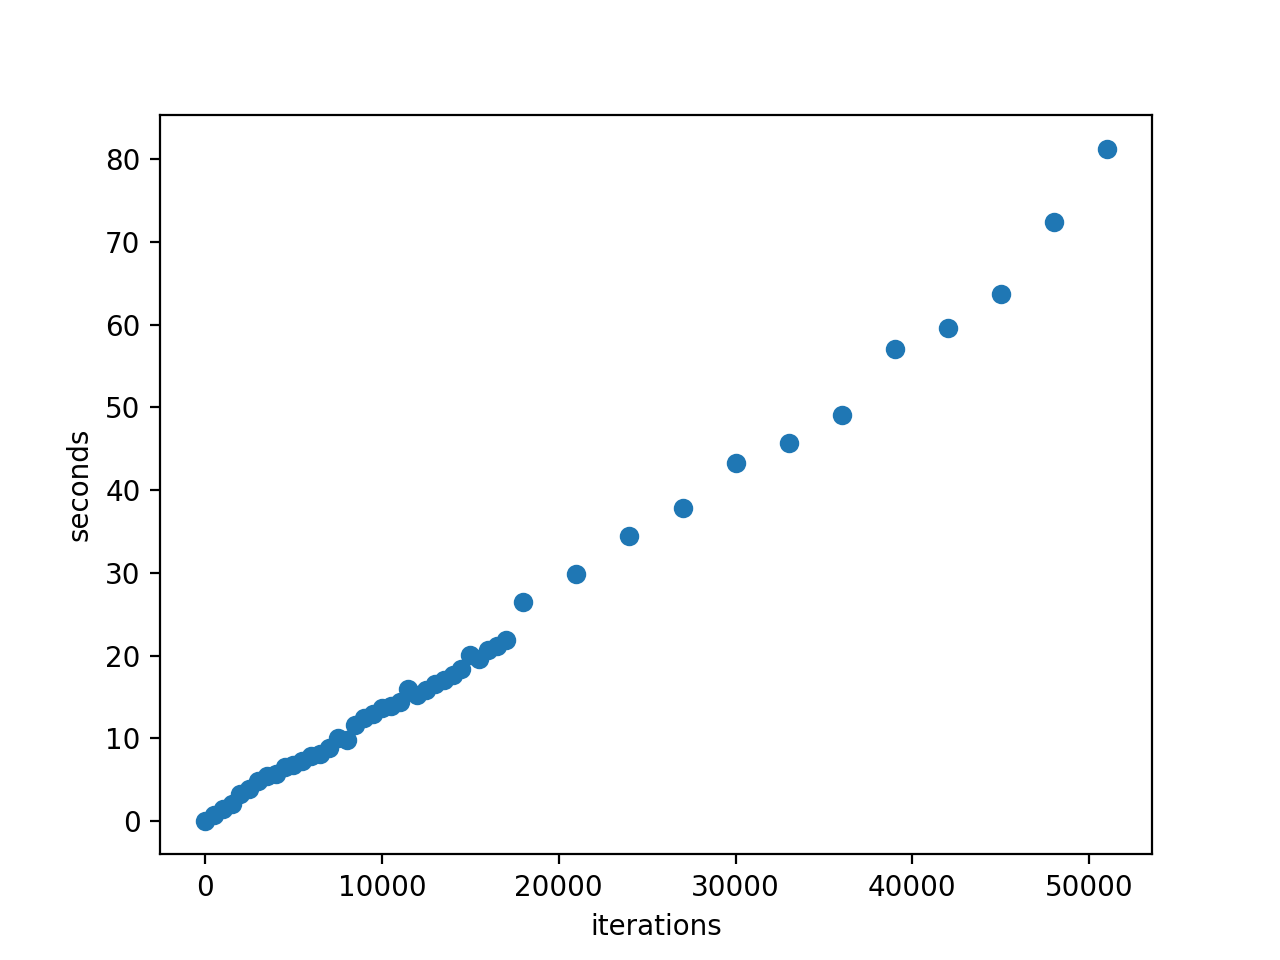

Keep in mind that the equation of the code with 51.000 iterations contains about 253.000 variables (153.001 f_* variables and 102.001 i_* variables)

## Appendix - Boolean satisfiability
In order to check the validity of our equation (composed, as we have seen, by init $\wedge$ tran $\wedge$ post) we look for `unsat` outcome. Why? 

Since the function `check()` has two possible outcomes (either sat or unsat), we cannot check validity **directly**. Let's take a look to the following tables:

$\mathrm{A}$ | $\mathrm{B}$ | $\mathrm{A}$ $\rightarrow$ ($\mathrm{B}$ $\rightarrow$ $\mathrm{A}$) | $\sim$ ($\mathrm{A}$ $\rightarrow$ ($\mathrm{B}$ $\rightarrow$ $\mathrm{A}$))
:---: |:---: | :---: | :---:
0 | 0 | 1 | 0
0 | 1 | 1 | 0
1 | 0 | 1 | 0
1 | 1 | 1 | 0

$\mathrm{A}$ | $\mathrm{B}$ | $\mathrm{A}$ $\rightarrow$ ($\mathrm{A}$ $\rightarrow$ $\mathrm{B}$) | $\sim$ ($\mathrm{A}$ $\rightarrow$ ($\mathrm{A}$ $\rightarrow$ $\mathrm{B}$))
:---: |:---: | :---: | :---:
0 | 0 | 1 | 0
0 | 1 | 1 | 0
1 | 0 | 0 | 1
1 | 1 | 1 | 0

Both $\mathrm{A}\rightarrow(\mathrm{B}\rightarrow\mathrm{A})$ and $\mathrm{A}\rightarrow(\mathrm{A}\rightarrow \mathrm{B})$ are satisfiable. Nevertheless the first one is more than simply satisfiable: it's a tautology. As we can see in the first table, the negation of a tautology is (of course) a contradiction. Thus, even if `valid` is not a possible outcome of Z3, we can check whether a formula is valid or not by proving that its negation is a contradiction.

Formula | Z3 outcome
:--- | :---
$\mathrm{A}$ $\rightarrow$ ($\mathrm{B}$ $\rightarrow$ $\mathrm{A}$) | sat
$\sim$ ($\mathrm{A}$ $\rightarrow$ ($\mathrm{B}$ $\rightarrow$ $\mathrm{A}$)) | unsat
$\mathrm{A}$ $\rightarrow$ ($\mathrm{A}$ $\rightarrow$ $\mathrm{B}$) | sat
$\sim$ ($\mathrm{A}$ $\rightarrow$ ($\mathrm{A}$ $\rightarrow$ $\mathrm{B}$)) | sat

Lastly, notice that when we call `model()`, it returns a model of the negated formula, i.e. a counterexample of the formula that we need. What is a **model**? A model is  a tuple of variable assignments such that they make the formula true. For example ($\mathrm{A}=0,\mathrm{B}=0$) is a model of $\mathrm{A}\rightarrow(\mathrm{A}\rightarrow \mathrm{B})$.